In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import wasserstein_distance
from statsmodels.distributions.empirical_distribution import ECDF
import datetime
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions,histfit
import fitter
import math
import random
from numpy import exp
import pyreadstat

from scipy.optimize import curve_fit

import json
# import nbimporter
# from Modelling_utils import my_function

#Avoiding Type 3 fonts in matplotlib plots
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'

In [2]:
font = {'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=2.0)
matplotlib.rc('lines', markersize=8)

In [3]:
res='results/'

# Datasets Reading

### MiD Data 2017
mobilität in deutschland

In [19]:
# data reading
'''
wegkm: wegelänge, path length
hvm: hauptverkehrsmittel, main mode of transport
hvm_diff2: hauptverkehrsmittel (stärker differenziert), more differentiated

'''
df_MiD=pd.read_csv('data/MiD2017_Wege.csv',decimal=',',sep=';',usecols=['wegkm','hvm','hvm_diff2','W_ZWECK','ST_JAHR','ST_MONAT'])
print(df_MiD.shape)
#exclude unwanted lines with "unknown" distance value et al
df_MiD=df_MiD[df_MiD.wegkm.isin([9994,9999,70703]) == False]
df_MiD.head(3)

(960619, 6)


,ST_MONAT,ST_JAHR,W_ZWECK,wegkm,hvm,hvm_diff2
0,3,2017,1,21.85,4,9
1,3,2017,5,0.39,1,1
2,3,2017,8,21.85,4,9


In [20]:
# Different transport modes extraction
df_MiD_walk =df_MiD[df_MiD.hvm.isin([1]) == True] # Walk
df_MiD_bike = df_MiD[df_MiD.hvm.isin([2]) == True] # Bicycle (incl. Ebike)
df_MiD_obike=df_MiD_bike[df_MiD_bike.hvm_diff2.isin([2])==True] #only Bike
df_MiD_autopass = df_MiD[df_MiD.hvm.isin([3]) == True] # Auto Passengers
df_MiD_autodriver = df_MiD[df_MiD.hvm.isin([4]) == True] # Auto Drivers

df_MiD_public=df_MiD[df_MiD.hvm.isin([5]) == True] #public
# Public Transport w/o long distance vehicles,short range
df_MiD_SRpublic=df_MiD_public[df_MiD_public.hvm_diff2.isin([19,20,21,22,23])==False] 
# long range
df_MiD_LRpublic=df_MiD_public[df_MiD_public.hvm_diff2.isin([20,21,22,23])==True] 

### NHTS17 Data
Travel behavior of the American public

trippub.csv:
data items collected for each trip made by each household member age 5+ on the household’s travel day (one record for each trip each person age 5+ made).

In [22]:
# data reading
# TRPMILES: Trip distance in miles, derived from route geometry returned
# TRPTRANS: Trip Mode, derived 
# WHYTRP1S: Trip purpose summary
df_Nhts=pd.read_csv('data/trippub_2017NHTS.csv',decimal='.',sep=',',usecols=["TRPMILES", "TRPTRANS","WHYTRP1S"])
print(df_Nhts.shape)
df_Nhts.head(3)

(923572, 3)


,TRPMILES,TRPTRANS,WHYTRP1S
0,5.244,3,20
1,5.149,3,1
2,84.004,6,1


In [23]:
# Different transport modes extraction and unit conversion to Km

df_Nhts_walk =df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([1]) == True]*1.60934 # Walk and transform to km
df_Nhts_bike = df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([2]) == True]*1.60934 # Bicycle and transform to km
#3auto 4suv 5van 6 pick up truck 18rentalcar
df_Nhts_auto=df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([3,4,5,6,18])==True]*1.60934   #Auto
# Public Transport short distance
#10school bus, 11public bus, 12paratransit / dial-a-ride, 13private/charter/tour/shutnhtse bus, 15amtrack / commuter rail, 16subway, 17taxi /limo (incl uber)
df_Nhts_SRpublic=df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([10,11,12,13,16,17])==True]*1.60934  
# long distance public transport
#14City-to-city bus (Greyhound, Megabus), 19Airplane, 20Boat/ferry/water taxi
df_Nhts_LRpublic=df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([14,19,20])==True]*1.60934  

# Power-law properties in short and medium-distance transport

Find the funtion $f(x)=C* \left( \dfrac{1}{x}\right) ^{\alpha}$ between two specific points for each dataset
 
Then calculate the error ( MSE or $error=\sum_{n=1}^{1000}\dfrac{|f(x_i)-g(x_i)|}{\dfrac{ f(x_i)+g(x_i)}{2}}$ ) between the function above and real data

In [10]:
'''
given the value of point x and whole data, calculate the point of y value in CCDF
'''
def cal_y_ccdf(data,x):
    
    sorted_data = np.sort(data)
    linspaced = np.linspace(0, 1, len(data), endpoint=False)
    y=1-linspaced
    
    return np.interp(x, sorted_data,y)

In [11]:
#To-do: describe the C, alpha
# Get C and alpha
def getC_alp(df_vec,X1,X2):
    
    # X1=t_err_min_distance
    # X2=t_err_max_distance
    Y1=cal_y_ccdf(df_vec,X1)
    Y2=cal_y_ccdf(df_vec,X2)
    
    alp=(math.log(Y1)-math.log(Y2))/(math.log(X2)-math.log(X1))
    C=Y1*(X1**alp)
    return alp,C,Y1,Y2

In [24]:
'''
There are a total of 4 sub-datasets, 3 of which have been annotated for successful execution of the script,
If you want to see the other datasets, uncomment them accordingly.

- Walking in MiD 2017
- MiD Bike 2017
- NHTS Bike 2017
- NHTS Short-Distance Public Transport 2017
'''
# Walking in MiD 2017
MiDwalk_data=df_MiD_walk['wegkm'].copy() 
# t_err_min_distance=2.9 #selected point1
# t_err_max_distance=30 #selected point2
# select the data trips between min and max distance to have a nicer observation
# min_distance=1
# max_distance=100
MiDwalk_data=MiDwalk_data[MiDwalk_data.between(1,100)]
MiDwalk_X1=2.9
MiDwalk_X2=30
MiDwalk_alp,MiDwalk_C,MiDwalk_Y1,MiDwalk_Y2=getC_alp(MiDwalk_data,MiDwalk_X1,MiDwalk_X2)
print('MiD Walking--Alpha,C,Y1,Y2:',MiDwalk_alp,MiDwalk_C,MiDwalk_Y1,MiDwalk_Y2,len(MiDwalk_data))

# Bicycling in MiD 2017 
MiDbike_data=df_MiD_obike['wegkm'].copy() 
MiDbike_data=MiDbike_data[MiDbike_data.between(1,100)]
MiDbike_X1=3.9
MiDbike_X2=39
# MiDbike_X2=50
MiDbike_alp,MiDbike_C,MiDbike_Y1,MiDbike_Y2=getC_alp(MiDbike_data,MiDbike_X1,MiDbike_X2)
print('MiD Bicycling--Alpha,C,Y1,Y2:',MiDbike_alp,MiDbike_C,MiDbike_Y1,MiDbike_Y2,len(MiDbike_data))

# Bicycling in Nhts  
NHTSbike_data=df_Nhts_bike.copy() 
NHTSbike_data=NHTSbike_data[NHTSbike_data.between(1,250)]
NHTSbike_X1=9
NHTSbike_X2=100
NHTSbike_alp,NHTSbike_C,NHTSbike_Y1,NHTSbike_Y2=getC_alp(NHTSbike_data,NHTSbike_X1,NHTSbike_X2)
print('NHTS Bicycling--Alpha,C,Y1,Y2:',NHTSbike_alp,NHTSbike_C,NHTSbike_Y1,NHTSbike_Y2)

# # NHTS Short-Distance Public Transport
NHTSsrpublic_data=df_Nhts_SRpublic.copy() #Short range public in Nhts17 
NHTSsrpublic_data=NHTSsrpublic_data[NHTSsrpublic_data.between(10,1000)]
NHTSsrpublic_X1=20
NHTSsrpublic_X2=500
NHTSsrpublic_alp,NHTSsrpublic_C,NHTSsrpublic_Y1,NHTSsrpublic_Y2=getC_alp(NHTSsrpublic_data,NHTSsrpublic_X1,NHTSsrpublic_X2)
print('NHTS shor public--Alpha,C,Y1,Y2:',NHTSsrpublic_alp,NHTSsrpublic_C,NHTSsrpublic_Y1,NHTSsrpublic_Y2,len(NHTSsrpublic_data))

MiD Walking--Alpha,C,Y1,Y2: 2.3770469505514424 5.831169620387757 0.46410251699805477 0.001797086991480265 69987
MiD Bicycling--Alpha,C,Y1,Y2: 1.6094954301515967 3.573131467621821 0.3996991380712311 0.009822856092865078 67639
NHTS Bicycling--Alpha,C,Y1,Y2: 1.9262785461716745 9.031364871599708 0.13110417276270975 0.001268224959104602
NHTS shor public--Alpha,C,Y1,Y2: 1.592486036855698 54.88584238995587 0.46514486675815236 0.0027630471014490616 9130


In [15]:
def ccdf_plot_all(datalist,titles):
    n=len(datalist)
    fig, axes = plt.subplots(1, n, sharey=True,figsize=(3.54*3,2.83*1.7))
    for i, (data, X1, X2, C, alp) in enumerate(datalist):
        ax=axes[i]
        sorted_data = np.sort(data)
        linspaced = np.linspace(0, 1, len(data), endpoint=False)
        ax.plot(sorted_data, 1-linspaced,label='Empirical data',rasterized=False,markersize=5,alpha=0.8,linewidth=5)
    
        # Number of samples to generate
        num_samples=20
        # 100 linearly spaced numbers
        s = np.linspace(X1,X2,num_samples)
        # the function
        t = C/(s**alp)
         # plot the function
        ax.plot(s,t, 'r',linewidth=6,label='Power-law')
    
        ax.set_yscale("log")
        ax.set_xscale("log")
        # ax.grid()
        ax.text(0.04, 0.04,titles[i],transform=ax.transAxes,
                fontsize=15,
                va='bottom', ha='left',
               bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.3'))
        if i == 0:
            handles, labels = ax.get_legend_handles_labels()

    fig.supxlabel('Trip Length (km)')
    fig.supylabel('CCDF')
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.05),
               ncol=2, fontsize=15, frameon=True, fancybox=True)
    # fig.legend(handles, labels, loc='center left',
    #        bbox_to_anchor=(0.6, 0.04),
    #        ncol=len(labels), fontsize=15, frameon=True, fancybox=True)

    plt.tight_layout()
    plt.savefig(res+'Short Distance.pdf', dpi=100, bbox_inches='tight')


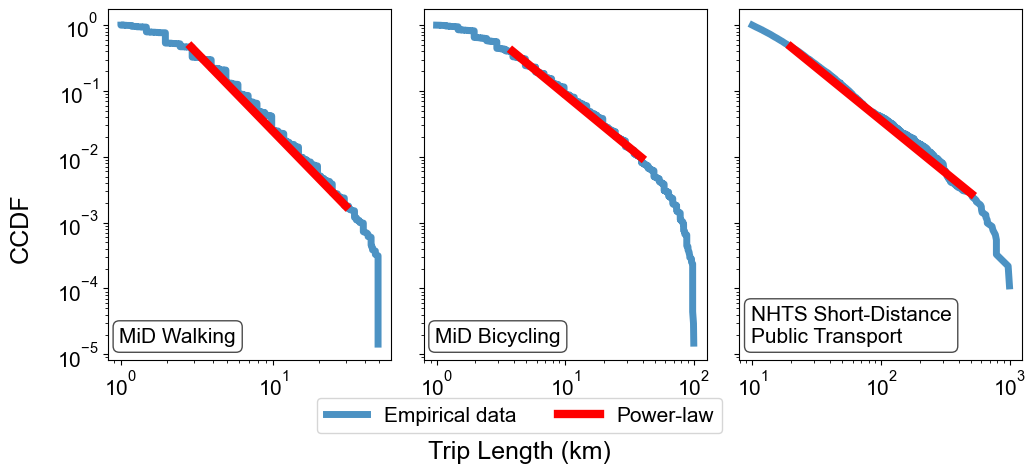

In [16]:
datalist=[(MiDwalk_data,MiDwalk_X1,MiDwalk_X2,MiDwalk_C,MiDwalk_alp),
         (MiDbike_data,MiDbike_X1,MiDbike_X2,MiDbike_C,MiDbike_alp),
         # (NHTSbike_data,NHTSbike_X1,NHTSbike_X2,NHTSbike_C,NHTSbike_alp),
         (NHTSsrpublic_data,NHTSsrpublic_X1,NHTSsrpublic_X2,NHTSsrpublic_C,NHTSsrpublic_alp)]
titles=['MiD Walking','MiD Bicycling','NHTS Short-Distance\nPublic Transport']
ccdf_plot_all(datalist,titles)